In [20]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"


opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [21]:
!apt-get update
!apt-get install -y fonts-noto


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                                      
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease                                    
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease                                    
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease                          
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as reposito

In [22]:
!pip install torch torchvision transformers opencv-python scikit-learn googletrans==4.0.0rc1

In [23]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle, class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [26]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label'], dtype='object')


In [27]:
print(df['label'].unique())


['Non Informative' 'Cyclone' 'Anthropogenic' 'Earthquake' 'River Erosion'
 'flood']


In [28]:
import pandas as pd

# Define the mapping
label_mapping = {
    'River Erosion': 3,
    'Cyclone': 1,
    'Anthropogenic': 4,
    'flood': 0,
    'Earthquake': 2
}

# Remove 'Non Informative' rows
df = df[df['label'] != 'Non Informative']

# Assign new integer labels
df['label'] = df['label'].map(label_mapping)

# Display updated labels
print(df['label'].unique())


[1 4 2 3 0]


In [29]:
print(df['label'].value_counts())

label
4    697
0    510
1    509
2    500
3    445
Name: count, dtype: int64


In [30]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [31]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Prepare data for TextDataset
X_train = train_data['caption'].values
y_train = train_data['label'].values
X_valid = valid_data['caption'].values
y_valid = valid_data['label'].values
X_test = test_data['caption'].values
y_test = test_data['label'].values


In [32]:
import random

# Random Deletion
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

# Random Swap
def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Character-level Noise
def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

# Combine all augmentations
def augment_bengali_text(text):
    # Step 1: Random Deletion
    text = random_deletion_bn(text, p=0.1)
    # Step 2: Random Swap
    text = random_swap_bn(text, n=1)
    # Step 3: Character-level noise
    text = char_noise_bn(text, p=0.03)
    return text

# Apply augmentation to your dataset
df['caption_aug'] = df['caption'].apply(augment_bengali_text)

print(df[['caption', 'caption_aug']].head(10))  # Check a sample


                                                caption  \
410       মংলায় ঝড়ের তাণ্ডবে বিদ্যুতের লাইন বিচ্ছিন্ন   
1483  ফিনল্যান্ডের উপকূলে প্লাস্টিক ও রাসায়নিক বর্জ...   
1578  গাজা ও ইউক্রেন যুদ্ধ নিয়ে যে সতর্কবার্তা দিল ...   
1534  চীনের শেয়ারবাজারে অস্থিরতা, বিনিয়োগকারীদের ব...   
1235  ইটভাটা ও কারখানার ধোঁয়ায় রাতের আকাশ কালো হয়...   
584   “তুরস্ক-সিরিয়া সীমান্তে ভূমিকম্পে ৪,০০০+ মানুষ...   
994   স্কুলের মাঠটি গত সপ্তাহেও ছিল, আজ সেখানে শুধু ...   
3137                   জুম আর্থে ঘূর্ণিঝড় দানার অবস্থান   
3127  ঘূর্ণিঝড়ের প্রভাবে টানা বৃষ্টি ও ঝোড়ো হাওয়ায় দ...   
486   সবকিছু হারিয়েও কিছু মানুষ এখনও লড়ে যাচ্ছে, বে...   

                                            caption_aug  
410                 মংলায় বিচ্ছিন্ন তাণ্ডবে লাইপ ঝড়ের  
1483  জীবন প্লাস্টিক ও রাসায়নিক বর্জ্যের সংমিশ্রণে ...  
1578  গাজা ও ইউক্রেন তুরস্ক নিয়ে যে সতর্কবার্তা দিল...  
1534  চীনের শেয়ারবাজারে অস্থিরতা, বড় বিনিয়োগকারীদ...  
1235  ইটভাটা উহছে কারখানার ধোঁযটায় রাতের কালো হয়ে ...  
58

In [33]:
from transformers import XLMRobertaTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Use XLM-Roberta's tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_ds = TextDataset(X_train, y_train, tokenizer)
valid_ds = TextDataset(X_valid, y_valid, tokenizer)
test_ds = TextDataset(X_test, y_test, tokenizer)

# Create data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)


In [34]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [35]:
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from tqdm import tqdm

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use XLM-Roberta for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',  # or 'xlm-roberta-large' for better performance
    num_labels=5
).to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=3e-6, weight_decay=0.2)
total_steps = len(train_dl) * 20
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(20):
    if early_stop:
        print("Early stopping triggered")
        break

    model.train()
    total_loss = 0
    correct, total = 0, 0
    for batch in tqdm(train_dl, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_dl)
    train_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in valid_dl:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(valid_dl)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_xlmr.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            early_stop = True


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Epoch 1, Training Loss: 1.6161, Training Accuracy: 21.62%
Validation Loss: 1.5941, Validation Accuracy: 22.18%


Epoch 2: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Epoch 2, Training Loss: 1.5114, Training Accuracy: 34.71%
Validation Loss: 1.3345, Validation Accuracy: 54.51%


Epoch 3: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Epoch 3, Training Loss: 1.1776, Training Accuracy: 61.59%
Validation Loss: 0.8720, Validation Accuracy: 75.75%


Epoch 4: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Epoch 4, Training Loss: 0.8811, Training Accuracy: 74.19%
Validation Loss: 0.6840, Validation Accuracy: 79.89%


Epoch 5: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


Epoch 5, Training Loss: 0.7232, Training Accuracy: 78.13%
Validation Loss: 0.5750, Validation Accuracy: 83.46%


Epoch 6: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Epoch 6, Training Loss: 0.6295, Training Accuracy: 82.77%
Validation Loss: 0.5451, Validation Accuracy: 82.33%


Epoch 7: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Epoch 7, Training Loss: 0.5434, Training Accuracy: 85.40%
Validation Loss: 0.4376, Validation Accuracy: 86.84%


Epoch 8: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 8, Training Loss: 0.4679, Training Accuracy: 87.53%
Validation Loss: 0.4176, Validation Accuracy: 86.84%


Epoch 9: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Epoch 9, Training Loss: 0.4267, Training Accuracy: 88.97%
Validation Loss: 0.3721, Validation Accuracy: 87.78%


Epoch 10: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 10, Training Loss: 0.3793, Training Accuracy: 90.04%
Validation Loss: 0.3607, Validation Accuracy: 86.84%


Epoch 11: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 11, Training Loss: 0.3434, Training Accuracy: 91.04%
Validation Loss: 0.3544, Validation Accuracy: 87.78%


Epoch 12: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Epoch 12, Training Loss: 0.3162, Training Accuracy: 91.85%
Validation Loss: 0.3378, Validation Accuracy: 88.53%


Epoch 13: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 13, Training Loss: 0.2836, Training Accuracy: 93.17%
Validation Loss: 0.3392, Validation Accuracy: 87.97%


Epoch 14: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 14, Training Loss: 0.2721, Training Accuracy: 93.30%
Validation Loss: 0.3362, Validation Accuracy: 88.91%


Epoch 15: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Epoch 15, Training Loss: 0.2689, Training Accuracy: 93.42%
Validation Loss: 0.3043, Validation Accuracy: 90.41%


Epoch 16: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Epoch 16, Training Loss: 0.2512, Training Accuracy: 93.80%
Validation Loss: 0.3080, Validation Accuracy: 89.85%


Epoch 17: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Epoch 17, Training Loss: 0.2355, Training Accuracy: 94.74%
Validation Loss: 0.3158, Validation Accuracy: 88.91%
No improvement in validation loss for 2 epochs. Stopping training.
Early stopping triggered


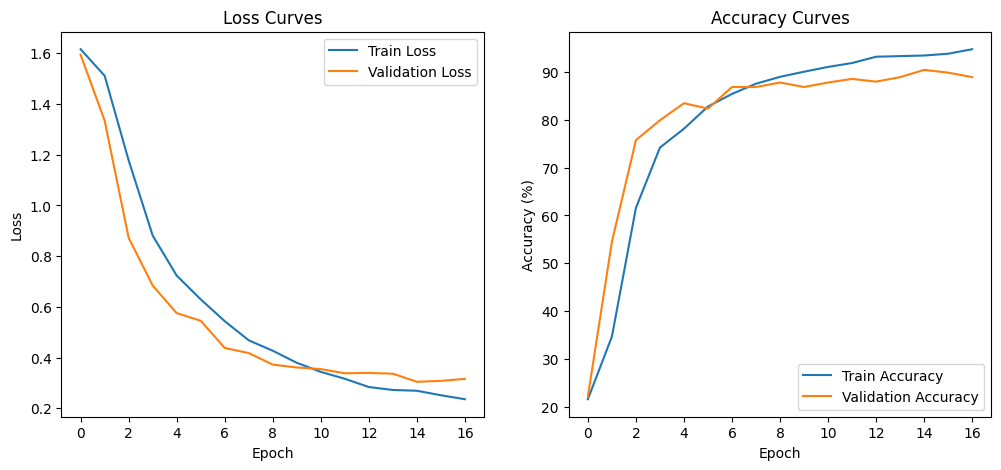

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.savefig('training_curves.png')  # Save the figure as a file

plt.show()


In [37]:
import pandas as pd

# Create a DataFrame for easy visualization
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses)+1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy (%)': train_accuracies,
    'Validation Accuracy (%)': val_accuracies
})

print(df)

# Optionally, save to a CSV file for later analysis
df.to_csv('training_metrics.csv', index=False)


    Epoch  Train Loss  Validation Loss  Train Accuracy (%)  \
0       1    1.616055         1.594128           21.616541   
1       2    1.511393         1.334510           34.711779   
2       3    1.177607         0.872045           61.591479   
3       4    0.881150         0.684019           74.185464   
4       5    0.723193         0.574995           78.132832   
5       6    0.629473         0.545123           82.769424   
6       7    0.543441         0.437627           85.401003   
7       8    0.467868         0.417581           87.531328   
8       9    0.426726         0.372109           88.972431   
9      10    0.379316         0.360728           90.037594   
10     11    0.343382         0.354382           91.040100   
11     12    0.316196         0.337824           91.854637   
12     13    0.283575         0.339212           93.170426   
13     14    0.272057         0.336208           93.295739   
14     15    0.268908         0.304281           93.421053   
15     1

Test Accuracy: 89.12%

Classification Report:
              precision    recall  f1-score   support

           0     0.8087    0.8857    0.8455       105
           1     0.9101    0.8020    0.8526       101
           2     0.8917    0.9068    0.8992       118
           3     0.9136    0.8605    0.8862        86
           4     0.9375    0.9756    0.9562       123

    accuracy                         0.8912       533
   macro avg     0.8923    0.8861    0.8879       533
weighted avg     0.8929    0.8912    0.8908       533



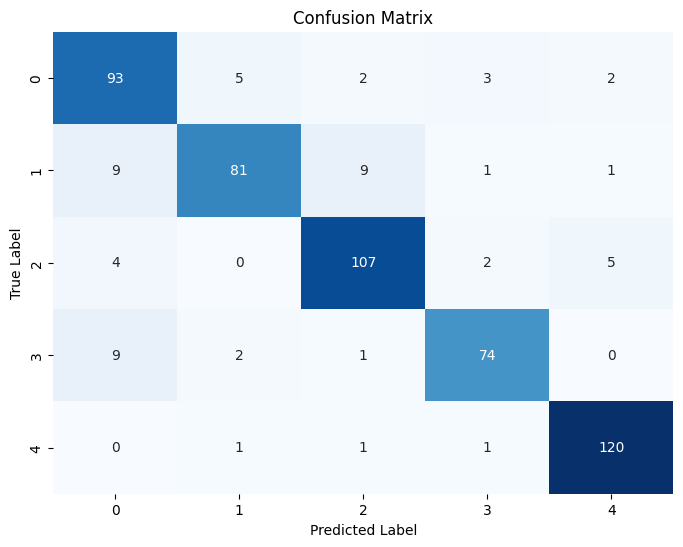

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_dl:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
accuracy = 100 * (sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels))
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
